In [1]:
import pandas as pd
import numpy as np
import sys
from omegaconf import OmegaConf
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('/home/hdieckhaus/scripts/ThermoMPNN/thermompnn')

from datasets.v2_datasets import MegaScaleDatasetv2, tied_featurize_mut
from train_thermompnn import parse_cfg
from trainer.v2_trainer import TransferModelPLv2

/home/hdieckhaus/miniforge3/envs/thermoMPNN/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# load calibration dataset
cfg = OmegaConf.merge(
    OmegaConf.load('../../wout.yaml'), 
    OmegaConf.load('../../infer.yaml')
)
cfg = parse_cfg(cfg)

ds = MegaScaleDatasetv2(cfg, 'val')
ds_test = MegaScaleDatasetv2(cfg, 'test')

100%|██████████| 31/31 [00:03<00:00,  9.48it/s]


Including 27328 direct single/double mutations
Final Dataset Size: 27328 
MEAN ddG: -0.6765517082716043


100%|██████████| 28/28 [00:03<00:00,  8.46it/s]

Including 28172 direct single/double mutations
Final Dataset Size: 28172 
MEAN ddG: -0.6881148904720964


In [3]:
# load trained QR model
mpath = '../checkpoints/CQR/QR.MT_epoch=98_val_ddG_spearman=0.78.ckpt'
gpu = 'cuda:0'

model = TransferModelPLv2.load_from_checkpoint(mpath, cfg=cfg, map_location=gpu, train_dataset=ds, val_dataset=ds).model

Loading model %s /home/hdieckhaus/scripts/ThermoMPNN/vanilla_model_weights/v_48_020.pt
setting ProteinMPNN dropout: 0.0
MLP HIDDEN SIZES: [384, 64, 32, 21]
Loading model %s /home/hdieckhaus/scripts/ThermoMPNN/vanilla_model_weights/v_48_020.pt
setting ProteinMPNN dropout: 0.0
MLP HIDDEN SIZES: [384, 64, 32, 21]
TransferModelv2CQR(
  (prot_mpnn): ProteinMPNN(
    (features): ProteinFeatures(
      (embeddings): PositionalEncodings(
        (linear): Linear(in_features=66, out_features=16, bias=True)
      )
      (edge_embedding): Linear(in_features=416, out_features=128, bias=False)
      (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (W_e): Linear(in_features=128, out_features=128, bias=True)
    (W_s): Embedding(21, 128)
    (encoder_layers): ModuleList(
      (0-2): 3 x EncLayer(
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
        (dropout3): Dropout(p=0.0, inplace=False)
        (norm1): LayerNorm

/home/hdieckhaus/miniforge3/envs/thermoMPNN/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [11]:
# get calibration set residuals

def run_inf(model, ds, cfg):
    """Run model on single dataset"""
    device = gpu

    loader = DataLoader(ds, collate_fn=lambda b: tied_featurize_mut(b, side_chains=False, esm=False), 
                        shuffle=False, num_workers=cfg.training.num_workers, batch_size=cfg.training.batch_size)


    preds, upper, lower, ddgs = [], [], [], []
    for n, batch in enumerate(tqdm(loader)):
        # move all parts to GPU
        X, S, mask, lengths, chain_M, chain_encoding_all, residue_idx, mut_positions, mut_wildtype_AAs, mut_mutant_AAs, mut_ddGs, atom_mask = batch

        X = X.to(device)
        S = S.to(device)
        mask = mask.to(device)
        lengths = torch.Tensor(lengths).to(device)
        chain_M = chain_M.to(device)
        chain_encoding_all = chain_encoding_all.to(device)
        residue_idx = residue_idx.to(device)
        mut_positions = mut_positions.to(device)
        mut_wildtype_AAs = mut_wildtype_AAs.to(device)
        mut_mutant_AAs = mut_mutant_AAs.to(device)
        mut_ddGs = mut_ddGs.to(device)
        atom_mask = torch.Tensor(atom_mask).to(device)

        pred, _ = model(X, S, mask, chain_M, residue_idx, chain_encoding_all, mut_positions, mut_wildtype_AAs, mut_mutant_AAs, mut_ddGs, atom_mask)

        if pred.shape[0] == 1:
            preds += [torch.squeeze(pred[..., 1], dim=-1).detach().cpu()]
            ddgs += [torch.squeeze(mut_ddGs, dim=-1).detach().cpu()]
            upper += [torch.squeeze(pred[..., 0], dim=-1).detach().cpu()]
            lower += [torch.squeeze(pred[..., 2], dim=-1).detach().cpu()]
        else:
            preds += list(torch.squeeze(pred[..., 1], dim=-1).detach().cpu())
            ddgs += list(torch.squeeze(mut_ddGs, dim=-1).detach().cpu())
            upper += list(torch.squeeze(pred[..., 0], dim=-1).detach().cpu())
            lower += list(torch.squeeze(pred[..., 2], dim=-1).detach().cpu())

    preds = np.squeeze(preds)
    ddgs = np.squeeze(ddgs)
    upper = np.squeeze(upper)
    lower = np.squeeze(lower)
    # return preds, ddgs, upper, lower, ds.df.WT_name
    return preds, ddgs, upper, lower, ds.df.pdb_id_corrected
    # return preds, ddgs, upper, lower, None



In [5]:
# run all necessary inf sets
preds_cal, ddgs_cal, upper_cal, lower_cal, WT_cal = run_inf(model, ds, cfg)
preds_test, ddgs_test, upper_test, lower_test, WT_test = run_inf(model, ds_test, cfg)

100%|██████████| 111/111 [00:20<00:00,  5.29it/s]


In [ ]:
import os
from datasets.v2_datasets import ddgBenchDatasetv2
from copy import deepcopy

cfg_fp = deepcopy(cfg)
cfg_fp.training.batch_size = 1

pdb_loc = os.path.join(cfg.data_loc.misc_data, 'protddg-bench-master/SSYM/pdbs')
csv_loc = os.path.join(cfg.data_loc.misc_data, 'protddg-bench-master/SSYM/ssym-5fold_clean_inv.csv')
ds_ssym = ddgBenchDatasetv2(cfg_fp, pdb_loc, csv_loc, flip=False)
preds_ssym, ddgs_ssym, upper_ssym, lower_ssym, _ = run_inf(model, ds_ssym, cfg_fp)


Reverse mutations: False


100%|██████████| 342/342 [00:03<00:00, 85.70it/s]


In [12]:
# load and run fp dataset

from datasets.v2_datasets import FireProtDatasetv2
from copy import deepcopy

cfg_fp = deepcopy(cfg)
cfg_fp.training.batch_size = 1

ds_fp = FireProtDatasetv2(cfg_fp, 'homologue-free')
preds_fp, ddgs_fp, upper_fp, lower_fp, WT_fp = run_inf(model, ds_fp, cfg_fp)

# ds_fp = FireProtDatasetv2(cfg_fp, 'train')
# preds_fp_train, ddgs_fp_train, upper_fp_train, lower_fp_train, WT_fp_train = run_inf(model, ds_fp, cfg_fp)

# ds_fp = FireProtDatasetv2(cfg_fp, 'test')
# preds_fp_test, ddgs_fp_test, upper_fp_test, lower_fp_test, WT_fp_test = run_inf(model, ds_fp, cfg_fp)


Total dataset size: (2578, 43)


100%|██████████| 2578/2578 [00:26<00:00, 95.81it/s]


In [ ]:
# filter for WT name and ddG range

range_cal = [-2.5, 4.6]
preds_subset = preds_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
lower_subset = lower_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
upper_subset = upper_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
WT_fp = WT_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
ddgs_subset = ddgs_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]

mask = WT_fp == '1EY0'
preds_fp = preds_subset[mask]
lower_fp = lower_subset[mask]
upper_fp = upper_subset[mask]
ddgs_fp = ddgs_subset[mask]

In [ ]:
ddgs_fp.shape

(501,)

Coverage rate: 55.97
Avg interval length: 1.85


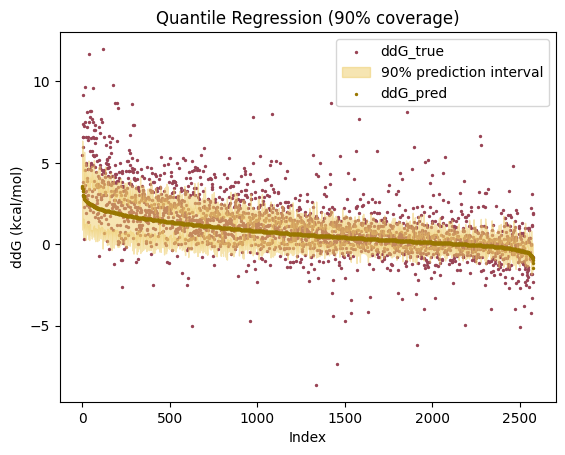

In [14]:
# calculate metrics and plot a QR dataset

def plot_ds(preds, ddgs, lower, upper):

    def sort_ddg(preds, upper, lower, ddgs):
        idx_sort = preds.argsort()
        return preds[idx_sort[::-1]], upper[idx_sort[::-1]], lower[idx_sort[::-1]], ddgs[idx_sort[::-1]]

    def get_coverage(upper, lower, ddgs):
     # calculate coverage rate and avg interval length

        covered = []
        for u, l, d in zip(upper, lower, ddgs):
            if u > l: # handle interval crossing artifacts
                up = u
                low = l
            else:
                up = l
                low = u
            if (d < up) and (d > low):
                covered.append(True)
            else:
                covered.append(False)

        lengths = [abs(u - l) for u, l in zip(upper, lower)]

        print('Coverage rate:', round(100. * np.sum(np.array(covered)) / len(covered), 2))
        print('Avg interval length:', round(np.mean(lengths), 2))

    preds, upper, lower, ddgs = sort_ddg(preds, upper, lower, ddgs)

    get_coverage(upper, lower, ddgs)

    f = 1
    idx = np.arange(preds.size)
    plt.scatter(idx[::f], ddgs[::f], color='#994455', s=2, label='ddG_true')
    plt.fill_between(idx[::f], lower[::f], upper[::f], alpha=0.5, color='#EECC66', label='90% prediction interval')
    plt.scatter(idx[::f], preds[::f], color='#997700', s=2, label='ddG_pred')
    plt.legend()
    plt.title('Quantile Regression (90% coverage)')
    plt.ylabel('ddG (kcal/mol)')
    plt.xlabel('Index')

    return 

# plot_ds(preds_cal, ddgs_cal, lower_cal, upper_cal)
# plot_ds(preds_test, ddgs_test, lower_test, upper_test)

plot_ds(preds_fp, ddgs_fp, lower_fp, upper_fp)
# plot_ds(preds_fp_train, ddgs_fp_train, lower_fp_train, upper_fp_train)
# plot_ds(preds_ssym, ddgs_ssym, lower_ssym, upper_ssym)

Q_eff: 90.00329332552693
0.06366364508867231 -0.006329631805420132
Coverage rate: 57.72
Avg interval length: 1.9


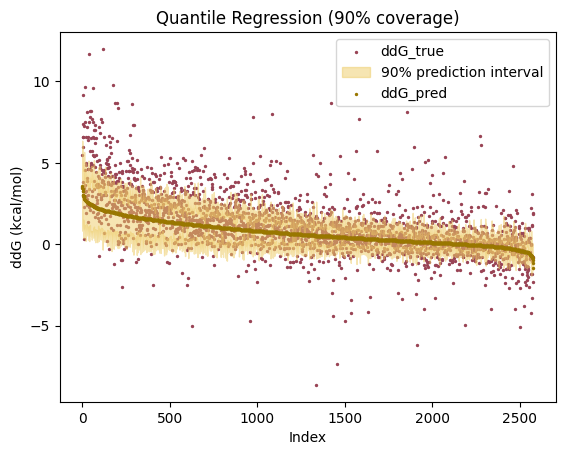

In [15]:
# calculate conformal adjustment(s)

def cqr_calibrate(ddgs, upper, lower, q=90):

    # calculate conformity scores
    a = lower - ddgs
    b = ddgs - upper
    E_i = np.max([a, b], axis=0)

    # add finite-sample correction
    n = lower.size
    q = q * (1 + (1/n))
    print('Q_eff:', q)
    # get quantile constants
    Q_lo = np.percentile(E_i, q=q)
    print(Q_lo)
    # correct upper/lower  bounds
    lower = lower - Q_lo
    upper = upper + Q_lo
    return upper, lower, Q_lo


def cqr_calibrate_asymm(ddgs, upper, lower, q=90):
    """Asymmetric extension of calibration"""
    # calculate conformity scores
    a = lower - ddgs
    b = ddgs - upper

    # add finite-sample correction
    n = lower.size
    q = q * (1 + (1/n))
    print('Q_eff:', q)
    # get quantile constants
    Q_lo = np.percentile(a, q=95) # correction to lower bound
    Q_hi = np.percentile(b, q=95) # correction to upper bound
    print(Q_lo, Q_hi)
    # correct upper/lower  bounds
    lower = lower - Q_lo
    upper = upper + Q_hi 
    return upper, lower, Q_lo, Q_hi

# up, low, Q_lo = cqr_calibrate(ddgs_cal, upper_cal, lower_cal)
# plot_ds(preds_cal, ddgs_cal, lower_cal - Q_lo, upper_cal + Q_lo)
# plot_ds(preds_test, ddgs_test, lower_test - Q_lo, upper_test + Q_lo)

up, low, Q_lo, Q_hi = cqr_calibrate_asymm(ddgs_cal, upper_cal, lower_cal)
# plot_ds(preds_cal, ddgs_cal, low, up)
# plot_ds(preds_test, ddgs_test, lower_test - Q_lo, upper_test + Q_hi)

# recalibrate w/FP data (larger range, higher error rate)
# range_cal = [-2.5, 4.6]
# preds_subset = preds_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
# lower_subset = lower_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
# upper_subset = upper_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]
# ddgs_subset = ddgs_fp[~(ddgs_fp > range_cal[1]) & ~(ddgs_fp < range_cal[0])]

# plot_ds(preds_subset, ddgs_subset, lower_subset, upper_subset)
# plot_ds(preds_subset, ddgs_subset, lower_subset - Q_lo, upper_subset + Q_lo)

# from sklearn.model_selection import train_test_split
# idx = np.arange(ddgs_fp.size)
# test, train = train_test_split(idx, test_size=0.1)
# up, low, Q_lo = cqr_calibrate(ddgs_fp[train], upper_fp[train], lower_fp[train])
# plot_ds(preds_fp[train], ddgs_fp[train], lower_fp[train] - Q_lo, upper_fp[train] + Q_lo)
# plot_ds(preds_fp[test], ddgs_fp[test], lower_fp[test] - Q_lo, upper_fp[test] + Q_lo)

# up, low, Q_lo, Q_hi = cqr_calibrate_asymm(ddgs_fp[train], upper_fp[train], lower_fp[train])
# plot_ds(preds_fp[test], ddgs_fp[test], lower_fp[test] - Q_lo, upper_fp[test] + Q_hi)
# plot_ds(preds_test, ddgs_test, lower_test - Q_lo, upper_test + Q_hi)
# plot_ds(preds_test, ddgs_test, lower_test - Q_lo, upper_test + Q_lo)

# up, low, Q_lo = cqr_calibrate(ddgs_fp, upper_fp, lower_fp)
plot_ds(preds_fp, ddgs_fp, lower_fp - Q_lo, upper_fp + Q_hi)


In [ ]:
ddgs_cal.min(), ddgs_cal.max()

(-2.4368627, 4.5548906)

In [10]:
from sklearn.metrics import root_mean_squared_error as rmse
from scipy.stats import pearsonr
# print(pearsonr(preds_fp, ddgs_fp)[0], rmse(preds_fp, ddgs_fp))

residuals = np.abs(preds_test - ddgs_test)
lengths = np.abs(upper_test - lower_test)

# pearsonr(preds_test, residuals)
pearsonr(residuals, lengths)
# pearsonr(preds_test, lengths)
# plt.scatter(preds_test, lengths, s=5)
# plt.xlabel('Pred ddG')
# plt.ylabel('Interval Length')
# plt.title('Pred ddG vs Interval Length')

PearsonRResult(statistic=0.41124777062444895, pvalue=0.0)

48.33759590792839
54.43313953488372
58.42349304482226
43.225806451612904
42.857142857142854
nan


/tmp/ipykernel_2884863/3245245693.py:27: RuntimeWarning: invalid value encountered in scalar divide
  cov = 100 * np.sum(cov) / len(cov)


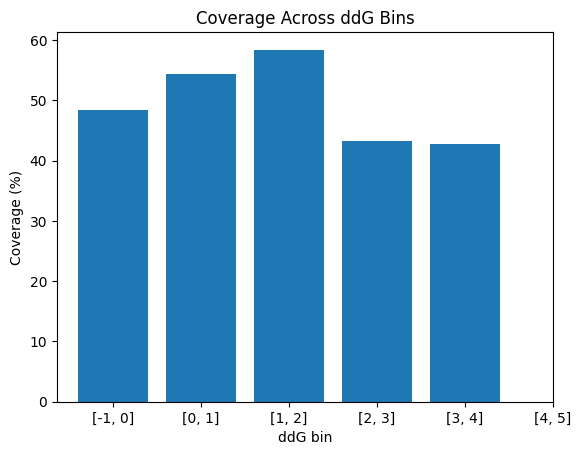

0.0
52.27272727272727
0.0
75.0
60.0
16.666666666666668
50.0
37.03703703703704
0.0
0.0
50.0
0.0
0.0
100.0
37.5
75.0
85.71428571428571
50.0
50.0
38.46153846153846
42.857142857142854
0.0
0.0
15.384615384615385
25.0
100.0
53.13059033989266
0.0
74.50980392156863
70.0
22.22222222222222
33.333333333333336
78.57142857142857
25.0
80.0
25.0
25.0
20.0
56.41025641025641
100.0
64.28571428571429
31.25
66.66666666666667
21.428571428571427
54.54545454545455
33.333333333333336
50.0
0.0
44.23076923076923
25.0
68.42105263157895
37.5
37.5
0.0
23.076923076923077
100.0
27.272727272727273
33.333333333333336
0.0
66.66666666666667
40.625
50.0
75.0
33.333333333333336
66.66666666666667
78.94736842105263
83.33333333333333
73.6842105263158
50.0
50.0
50.0
0.0
59.25925925925926
58.064516129032256
50.0
25.0
62.45954692556634
26.666666666666668
41.666666666666664
44.44444444444444
48.10126582278481
0.0
30.76923076923077
33.333333333333336
50.0
100.0
48.38709677419355
64.28571428571429
63.768115942028984


/home/hdieckhaus/miniforge3/envs/thermoMPNN/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname E identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


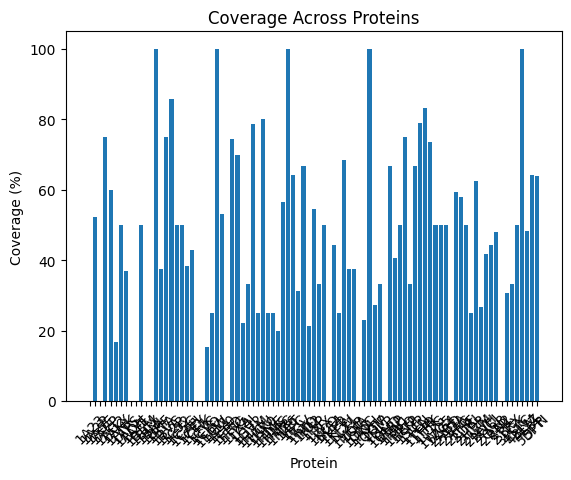

In [19]:
def plot_lengths(preds, ddgs, upper, lower):
    """Plot lengths and residuals"""

    residuals = np.abs(preds - ddgs)
    lengths = upper - lower
    df = pd.DataFrame({'Residual(abs)': residuals, 'Length': lengths})
    sns.jointplot(df, x='Residual(abs)', y='Length', color='#225555')
    from scipy.stats import spearmanr
    print('SCC (Abs Error vs Length) %s' % str(spearmanr(residuals, lengths)[0]))

    return


def check_coverage(preds, ddgs, upper, lower, wtn):
    """Checks for marginal vs conditional coverage"""

    # coverage by ddG bin
    bounds = np.arange(-1, 6)
    coverages = []
    for b in range(bounds.size - 1):
        mask = (preds > bounds[b]) & (preds < bounds[b + 1])
        ddgs_tmp = ddgs[mask]
        upper_tmp = upper[mask]
        lower_tmp = lower[mask]
        # get coverage for each chunk
        cov = [(d > l) and (d < u) for d, l, u in zip(ddgs_tmp, lower_tmp, upper_tmp)]
        cov = 100 * np.sum(cov) / len(cov)
        coverages.append(cov)
        print(cov)
    plt.bar(bounds[:-1], coverages)
    plt.ylabel('Coverage (%)')
    plt.xlabel('ddG bin')
    plt.xticks(ticks=np.arange(-1, 5), labels=[
        '[-1, 0]', '[0, 1]', '[1, 2]', '[2, 3]', '[3, 4]', '[4, 5]'
    ])
    plt.title('Coverage Across ddG Bins')
    plt.show()

    # coverage by WT name
    coverages = []
    wtn_un = np.unique(wtn)
    for wt in wtn_un:
        mask = wt == wtn
        ddgs_tmp = ddgs[mask]
        upper_tmp = upper[mask]
        lower_tmp = lower[mask]
        cov = [(d > l) and (d < u) for d, l, u in zip(ddgs_tmp, lower_tmp, upper_tmp)]
        cov = 100 * np.sum(cov) / len(cov)
        print(cov)
        coverages.append(cov)

    plt.bar(wtn_un, coverages)
    plt.xlabel('Protein')
    plt.ylabel('Coverage (%)')
    plt.title('Coverage Across Proteins')
    plt.xticks(rotation=45)
    plt.show()
    return

# plot_lengths(preds_fp, ddgs_fp, upper_fp - Q_lo, lower_fp + Q_hi)
# plot_lengths(preds_test, ddgs_test, upper_test - Q_lo, lower_test + Q_lo)
# check_coverage(preds_test, ddgs_test, upper_test - Q_lo, lower_test + Q_hi, WT_test)
check_coverage(preds_fp, ddgs_fp, upper_fp - Q_lo, lower_fp + Q_hi, WT_fp)

In [ ]:
np.min(preds_test)

-0.8392144